In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Test the model
if __name__ == "__main__":
    # Example usage
    model = MLP()
    print(model)

    # Create random input
    x = torch.randn(1, 28, 28)  # Assuming input image size of 28x28
    # Forward pass
    output = model(x)
    print("Output shape:", output.shape)
    import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders for training, validation, and test sets
batch_size = 64
validation_split = .1
shuffle_dataset = True

# Creating data indices for training and validation splits
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the neural network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (
    100 * correct / total))

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders for training, validation, and test sets
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0001, 0.00001]
num_epochs = 10

best_accuracy = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f'Training with batch size {batch_size} and learning rate {lr}')
        
        # Creating data loaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the neural network
        class MLP(nn.Module):
            def __init__(self):
                super(MLP, self).__init__()
                self.fc1 = nn.Linear(784, 100)
                self.fc2 = nn.Linear(100, 50)
                self.fc3 = nn.Linear(50, 10)

            def forward(self, x):
                x = x.view(-1, 784)  # Flatten the input
                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = self.fc3(x)
                return x

        # Instantiate the model, loss function, and optimizer
        model = MLP()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Validation accuracy: {accuracy}')

        # If the current hyperparameters result in higher validation accuracy, update the best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams['batch_size'] = batch_size
            best_hyperparams['lr'] = lr

print('Best hyperparameters:', best_hyperparams)
print('Best validation accuracy:', best_accuracy)

# Finally, test the model with the best hyperparameters
best_batch_size = best_hyperparams['batch_size']
best_lr = best_hyperparams['lr']

# Creating data loaders with best hyperparameters
best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
best_test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Define and train the model with the best hyperparameters
best_model = MLP()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for i, data in enumerate(best_train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

        running_loss += loss.item()

print('Finished Training with best hyperparameters')

# Test the model with the best hyperparameters
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in best_test_loader:
        images, labels = data
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set with best hyperparameters:', 100 * correct / total)


MLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
Output shape: torch.Size([1, 10])
[1,   100] loss: 0.950
[1,   200] loss: 0.586
[1,   300] loss: 0.520
[1,   400] loss: 0.498
[1,   500] loss: 0.482
[1,   600] loss: 0.453
[1,   700] loss: 0.464
[1,   800] loss: 0.447
[2,   100] loss: 0.407
[2,   200] loss: 0.410
[2,   300] loss: 0.406
[2,   400] loss: 0.398
[2,   500] loss: 0.404
[2,   600] loss: 0.400
[2,   700] loss: 0.372
[2,   800] loss: 0.388
[3,   100] loss: 0.367
[3,   200] loss: 0.360
[3,   300] loss: 0.360
[3,   400] loss: 0.359
[3,   500] loss: 0.349
[3,   600] loss: 0.360
[3,   700] loss: 0.356
[3,   800] loss: 0.361
[4,   100] loss: 0.324
[4,   200] loss: 0.337
[4,   300] loss: 0.316
[4,   400] loss: 0.336
[4,   500] loss: 0.338
[4,   600] loss: 0.342
[4,   700] loss: 0.319
[4,   800] loss: 0.325
[5,   100] loss: 0.310
[5,   200] loss: 

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders for training, validation, and test sets
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0001, 0.00001]
num_epochs = 10

best_accuracy = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f'Training with batch size {batch_size} and learning rate {lr}')
        
        # Creating data loaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the neural network
        class MLP(nn.Module):
            def __init__(self):
                super(MLP, self).__init__()
                self.fc1 = nn.Linear(784, 100)
                self.fc2 = nn.Linear(100, 50)
                self.fc3 = nn.Linear(50, 10)

            def forward(self, x):
                x = x.view(-1, 784)  # Flatten the input
                x = nn.ReLU()(self.fc1(x))
                x = nn.ReLU()(self.fc2(x))
                x = self.fc3(x)
                return x

        # Instantiate the model, loss function, and optimizer
        model = MLP()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Validation accuracy: {accuracy}')

        # If the current hyperparameters result in higher validation accuracy, update the best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams['batch_size'] = batch_size
            best_hyperparams['lr'] = lr

print('Best hyperparameters:', best_hyperparams)
print('Best validation accuracy:', best_accuracy)

# Finally, test the model with the best hyperparameters
best_batch_size = best_hyperparams['batch_size']
best_lr = best_hyperparams['lr']

# Creating data loaders with best hyperparameters
best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
best_test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Define and train the model with the best hyperparameters
best_model = MLP()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for i, data in enumerate(best_train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

        running_loss += loss.item()

print('Finished Training with best hyperparameters')

# Test the model with the best hyperparameters
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in best_test_loader:
        images, labels = data
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set with best hyperparameters:', 100 * correct / total)


Training with batch size 32 and learning rate 0.001
Validation accuracy: 0.9162666666666667
Training with batch size 32 and learning rate 0.0001
Validation accuracy: 0.8828166666666667
Training with batch size 32 and learning rate 1e-05
Validation accuracy: 0.825
Training with batch size 64 and learning rate 0.001
Validation accuracy: 0.90845
Training with batch size 64 and learning rate 0.0001
Validation accuracy: 0.8753833333333333
Training with batch size 64 and learning rate 1e-05
Validation accuracy: 0.8069833333333334
Training with batch size 128 and learning rate 0.001
Validation accuracy: 0.9040833333333333
Training with batch size 128 and learning rate 0.0001
Validation accuracy: 0.8692333333333333
Training with batch size 128 and learning rate 1e-05
Validation accuracy: 0.7903
Best hyperparameters: {'batch_size': 32, 'lr': 0.001}
Best validation accuracy: 0.9162666666666667
Finished Training with best hyperparameters
Accuracy on the test set with best hyperparameters: 88.09


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders for training, validation, and test sets
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0001, 0.00001]
num_epochs = 10

best_accuracy = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f'Training with batch size {batch_size} and learning rate {lr}')
        
        # Creating data loaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the neural network
        class MLP(nn.Module):
            def __init__(self):
                super(MLP, self).__init__()
                self.fc1 = nn.Linear(784, 100)
                self.fc2 = nn.Linear(100, 50)
                self.fc3 = nn.Linear(50, 10)

            def forward(self, x):
                x = x.view(-1, 784)  # Flatten the input
                x = nn.Sigmoid()(self.fc1(x))
                x = nn.Sigmoid()(self.fc2(x))
                x = self.fc3(x)
                return x

        # Instantiate the model, loss function, and optimizer
        model = MLP()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Validation accuracy: {accuracy}')

        # If the current hyperparameters result in higher validation accuracy, update the best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams['batch_size'] = batch_size
            best_hyperparams['lr'] = lr

print('Best hyperparameters:', best_hyperparams)
print('Best validation accuracy:', best_accuracy)

# Finally, test the model with the best hyperparameters
best_batch_size = best_hyperparams['batch_size']
best_lr = best_hyperparams['lr']

# Creating data loaders with best hyperparameters
best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
best_test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Define and train the model with the best hyperparameters
best_model = MLP()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for i, data in enumerate(best_train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

        running_loss += loss.item()

print('Finished Training with best hyperparameters')

# Test the model with the best hyperparameters
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in best_test_loader:
        images, labels = data
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set with best hyperparameters:', 100 * correct / total)


Training with batch size 32 and learning rate 0.001
Validation accuracy: 0.9082
Training with batch size 32 and learning rate 0.0001
Validation accuracy: 0.8628166666666667
Training with batch size 32 and learning rate 1e-05
Validation accuracy: 0.73145
Training with batch size 64 and learning rate 0.001
Validation accuracy: 0.9107
Training with batch size 64 and learning rate 0.0001
Validation accuracy: 0.84935
Training with batch size 64 and learning rate 1e-05
Validation accuracy: 0.65485
Training with batch size 128 and learning rate 0.001
Validation accuracy: 0.9016666666666666
Training with batch size 128 and learning rate 0.0001
Validation accuracy: 0.8217
Training with batch size 128 and learning rate 1e-05
Validation accuracy: 0.5574
Best hyperparameters: {'batch_size': 64, 'lr': 0.001}
Best validation accuracy: 0.9107
Finished Training with best hyperparameters
Accuracy on the test set with best hyperparameters: 87.93


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders for training, validation, and test sets
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0001, 0.00001]
num_epochs = 10

best_accuracy = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f'Training with batch size {batch_size} and learning rate {lr}')
        
        # Creating data loaders with new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the neural network
        class MLP(nn.Module):
            def __init__(self):
                super(MLP, self).__init__()
                self.fc1 = nn.Linear(784, 100)
                self.dropout1 = nn.Dropout(0.2)
                self.fc2 = nn.Linear(100, 50)
                self.dropout2 = nn.Dropout(0.2)
                self.fc3 = nn.Linear(50, 10)

            def forward(self, x):
                x = x.view(-1, 784)  # Flatten the input
                x = nn.ReLU()(self.fc1(x))
                x = self.dropout1(x)
                x = nn.ReLU()(self.fc2(x))
                x = self.dropout2(x)
                x = self.fc3(x)
                return x

        # Instantiate the model, loss function, and optimizer
        model = MLP()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        # Validate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Validation accuracy: {accuracy}')

        # If the current hyperparameters result in higher validation accuracy, update the best hyperparameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams['batch_size'] = batch_size
            best_hyperparams['lr'] = lr

print('Best hyperparameters:', best_hyperparams)
print('Best validation accuracy:', best_accuracy)

# Finally, test the model with the best hyperparameters
best_batch_size = best_hyperparams['batch_size']
best_lr = best_hyperparams['lr']

# Creating data loaders with best hyperparameters
best_train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
best_test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Define and train the model with the best hyperparameters
best_model = MLP()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_lr)
for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for i, data in enumerate(best_train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

        running_loss += loss.item()

print('Finished Training with best hyperparameters')

# Test the model with the best hyperparameters
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in best_test_loader:
        images, labels = data
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set with best hyperparameters:', 100 * correct / total)


Training with batch size 32 and learning rate 0.001
Validation accuracy: 0.8969166666666667
Training with batch size 32 and learning rate 0.0001
Validation accuracy: 0.88435
Training with batch size 32 and learning rate 1e-05
Validation accuracy: 0.8104
Training with batch size 64 and learning rate 0.001
Validation accuracy: 0.8997833333333334
Training with batch size 64 and learning rate 0.0001
Validation accuracy: 0.8720666666666667
Training with batch size 64 and learning rate 1e-05
Validation accuracy: 0.7884833333333333
Training with batch size 128 and learning rate 0.001
Validation accuracy: 0.9041166666666667
Training with batch size 128 and learning rate 0.0001
Validation accuracy: 0.8620333333333333
Training with batch size 128 and learning rate 1e-05
Validation accuracy: 0.7726666666666666
Best hyperparameters: {'batch_size': 128, 'lr': 0.001}
Best validation accuracy: 0.9041166666666667
Finished Training with best hyperparameters
Accuracy on the test set with best hyperparam

Epoch [1/10], Train Loss: 0.2665, Validation Accuracy: 0.9082, Test Accuracy: 0.8803
Epoch [2/10], Train Loss: 0.2533, Validation Accuracy: 0.9072, Test Accuracy: 0.8772
Epoch [3/10], Train Loss: 0.2436, Validation Accuracy: 0.9120, Test Accuracy: 0.8798
Epoch [4/10], Train Loss: 0.2352, Validation Accuracy: 0.9124, Test Accuracy: 0.8793
Epoch [5/10], Train Loss: 0.2288, Validation Accuracy: 0.9208, Test Accuracy: 0.8826
Epoch [6/10], Train Loss: 0.2204, Validation Accuracy: 0.9215, Test Accuracy: 0.8838
Epoch [7/10], Train Loss: 0.2117, Validation Accuracy: 0.9261, Test Accuracy: 0.8846
Epoch [8/10], Train Loss: 0.2062, Validation Accuracy: 0.9256, Test Accuracy: 0.8848
Epoch [9/10], Train Loss: 0.1982, Validation Accuracy: 0.9278, Test Accuracy: 0.8868
Epoch [10/10], Train Loss: 0.1949, Validation Accuracy: 0.9351, Test Accuracy: 0.8906


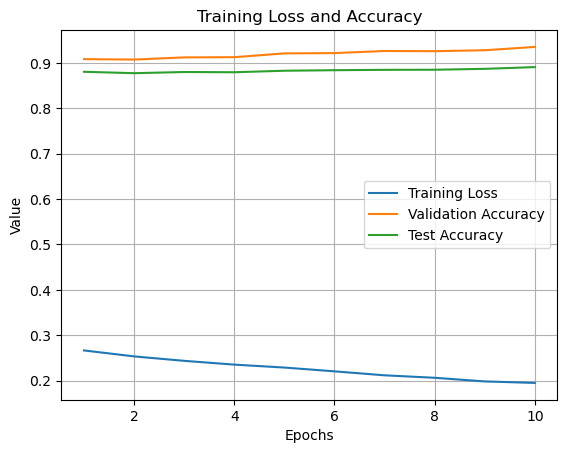

In [2]:
import matplotlib.pyplot as plt

# Define lists to store training loss, validation accuracy, and test accuracy
train_losses = []
val_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(best_train_loader, 0):
        inputs, labels = data
        best_optimizer.zero_grad()

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()

        running_loss += loss.item()

    # Calculate validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # Calculate test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in best_test_loader:
            images, labels = data
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    # Append training loss
    train_losses.append(running_loss / len(train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the curves
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('training_curves.png')

# Show plot
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 5, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(5, 5, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(5 * 4 * 4, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 5 * 4 * 4)  # Flatten the input for the fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion MNIST dataset and apply transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Split dataset into training, validation, and test sets
# Split dataset into training, validation, and test sets
train_size = 50000
val_size = 10000
test_size = 10000

lengths = [train_size, val_size, test_size]
train_data, val_data, test_data = random_split(dataset, lengths)


# DataLoader for each set
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {100 * accuracy:.2f}%")


ValueError: Sum of input lengths does not equal the length of the input dataset!